# Rubisco data

In [222]:
%pylab inline
import h5py, os
import spimage, condor
from matplotlib.colors import LogNorm
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


Loading data from files

In [5]:
directory = '/Users/max.hantke/data/xfel'

In [378]:
filename_bg     = os.path.join(directory, 'amol3416_r0256_ol3_small.h5')
filename_sample = os.path.join(directory, 'amol3416_r0252_ol3_small.h5')
filename_dark   = os.path.join(directory, 'amol3416_r0257_ol3_small.h5')

In [379]:
N = 20000
#with h5py.File(filename_dark, 'r') as f:
#    data_dark = asarray(f['/entry_1/data_1/data'][-N:])
#    mask_dark = asarray(f['/entry_1/data_1/mask'][-N:]) == False
with h5py.File(filename_bg, 'r') as f:
    print("Bg: %i" % f['/entry_1/data_1/data'].shape[0])
    data_bg = asarray(f['/entry_1/data_1/data'][:N])
    mask_bg = asarray(f['/entry_1/data_1/mask'][:N]) == False
    gmd_bg = asarray(f['/entry_1/experiment/pulse_energy'][:N])
with h5py.File(filename_sample, 'r') as f:
    print("Sample: %i" % f['/entry_1/data_1/data'].shape[0])
    data_sample = asarray(f['/entry_1/data_1/data'])
    mask_sample = asarray(f['/entry_1/data_1/mask']) == False
    gmd_sample = asarray(f['/entry_1/experiment/pulse_energy'])

Bg: 24659
Sample: 124489


Masking out odd pixels and pixels that do not follow Poissonian distribution

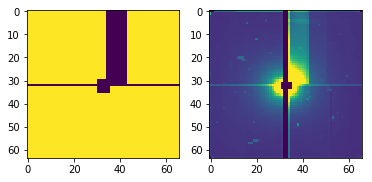

In [380]:
fig, axs = subplots(1, 2)
mask_odd = np.ones(shape=data_bg[0].shape, dtype=np.bool)
mask_odd[:32,34:34+9] = False
mask_odd[32,:] = False
mask_odd[30:36,30:36] = False
axs[0].imshow(mask_odd)
axs[1].imshow(data_bg.std(axis=0), vmax=10)

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


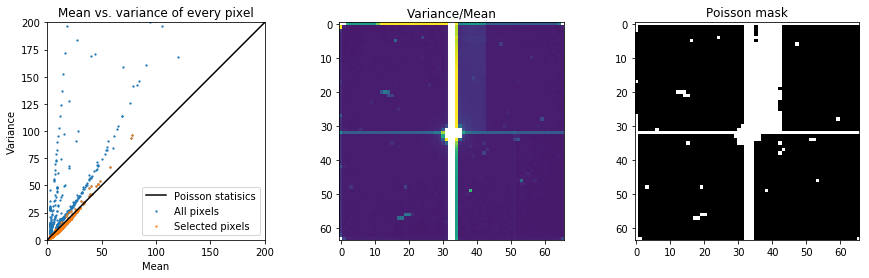

In [381]:
data_bg_var = data_bg[gmd_bg>0.5,:,:].var(axis=0)
data_bg_mean = data_bg[gmd_bg>0.5,:,:].mean(axis=0)
mask_poisson = abs(1-data_bg_var/data_bg_mean) < 0.3

fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 4))
ax1.set_title('Mean vs. variance of every pixel')
ax1.scatter(data_bg_mean.ravel(), data_bg_var.ravel(), s=1.5, label='All pixels')
ax1.scatter(data_bg_mean[mask_poisson].ravel(), data_bg_var[mask_poisson].ravel(), s=1.5, label='Selected pixels')
ax1.plot([0, 200], [0, 200], color='k', label='Poisson statisics')
ax1.legend()
ax1.set_ylabel('Variance')
ax1.set_xlabel('Mean')
ax1.set_ylim(0, 200)
ax1.set_xlim(0, 200)
ax1.set_aspect(1.)
ax2.set_title('Variance/Mean')
ax2.imshow(data_bg_var/data_bg_mean, vmin=0, vmax=10)
ax3.set_title('Poisson mask')
ax3.imshow(mask_poisson, vmin=0, vmax=1, cmap='binary')


Apply masks

In [382]:
mask0 = mask_poisson*mask_odd
mask_sample *= mask0
mask_bg *= mask0

In [383]:
#imgs_dark = data_dark*mask_dark
imgs_bg = data_bg*mask_bg
imgs_sample = data_sample*mask_sample

Count number of photons per pattern

In [384]:
#nph_dark = imgs_dark.sum(axis=1).sum(axis=1)
nph_bg = imgs_bg.sum(axis=1).sum(axis=1)
nph_sample = imgs_sample.sum(axis=1).sum(axis=1)

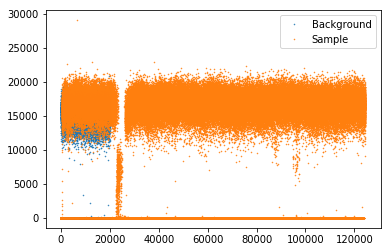

In [385]:
plot(nph_bg, '.', label='Background', ms=1.)
plot(nph_sample, '.', label='Sample', ms=1.)
#plot(nph_dark, '.', label='Dark')
legend()

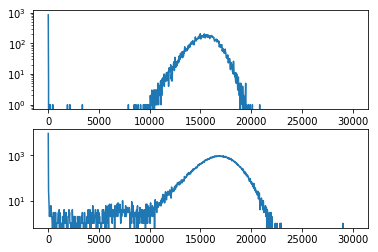

In [386]:
fig, axs = subplots(2, 1)
H_bg, s = histogram(nph_bg, 1000, range=(0, 30000))
H_sample, s = histogram(nph_sample, 1000, range=(0, 30000))
sc = s[:-1] + (s[1]-s[0])/2.
axs[0].semilogy(sc, H_bg)
axs[1].semilogy(sc, H_sample)

Look at data

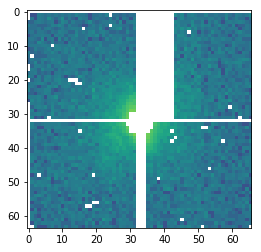

In [387]:
i_sample = nph_sample.argsort()[-2]
imshow(imgs_sample[i_sample], norm=LogNorm(vmin=0.1, vmax=1000))

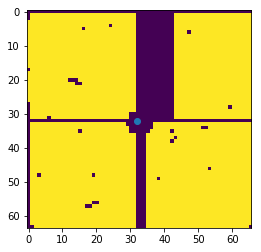

In [388]:
i = nph_sample.argmax()
imshow(mask_sample[i])
scatter([32], [32])

Fit data to sphere model

In [389]:
cx = 32
cy = 32
wavelength = condor.utils.photon.Photon(energy_eV=800.).get_wavelength()
pixelsize = 75E-6 * 16
distance = 0.130
rpix, _ = spimage.radialMeanImage(img=data_sample[0], msk=mask_sample[0], cx=cx, cy=cy, output_r=True)
qpix = np.asarray([condor.utils.scattering_vector.q_from_p(p=np.array([p*pixelsize, 0., distance]), wavelength=wavelength) for p in rpix]).sum(axis=1)

Ir_sphere = lambda K, diameter: condor.utils.sphere_diffraction.I_sphere_diffraction(K=K, q=qpix, r=diameter/2*1E-9)

def fit_sphere(I, K_guess, d_guess, bootstrap):
    sel = rpix < 10
    err = lambda v: ((Ir_sphere(v[0], v[1])-I)[sel]**2).sum()
    v0 = (K_guess, d_guess)
    res = scipy.optimize.minimize(err, v0)
    return res.x, res.fun

21.28436809675507 48.0542417511


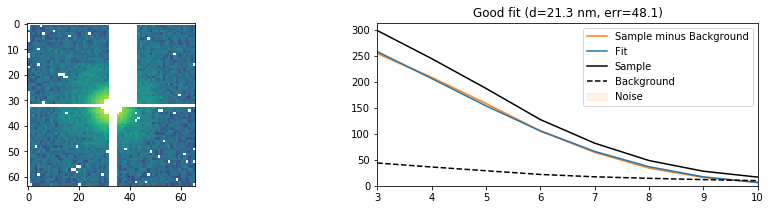

28.009333358970206 35.6444867013


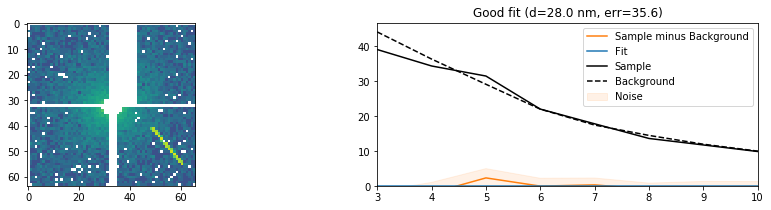

24.218026526228776 50.4430571283


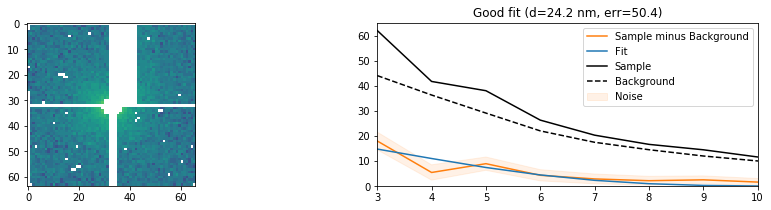

15.247539068980913 8.66349223784


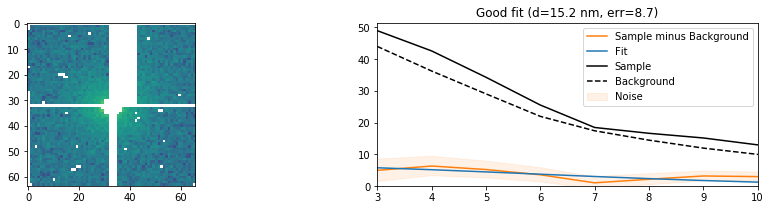

11.92770900784281 6.46426505965


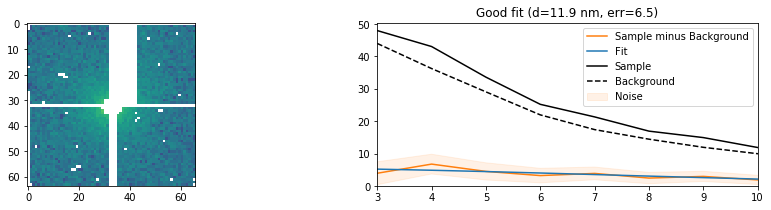

12.413030023278905 4.91583730883


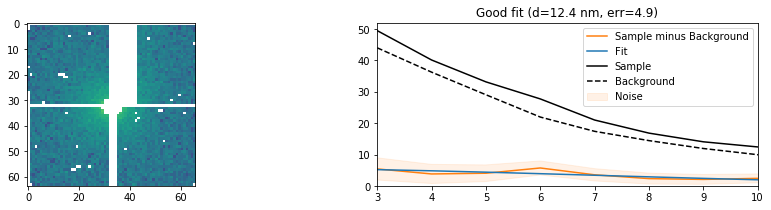

11.153335395937091 35.3974049936


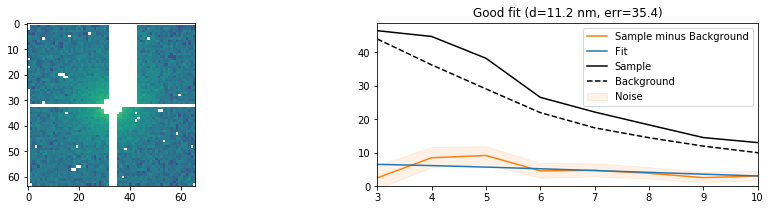

8.536586785807968 6.57278782121


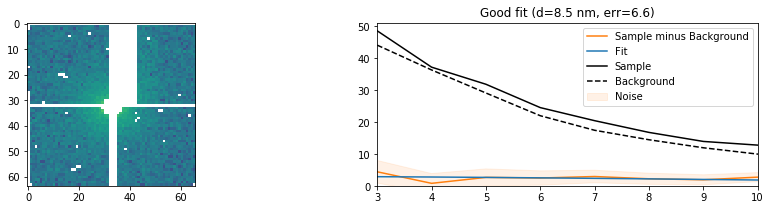

0.0011343957489246582 37.3943563979


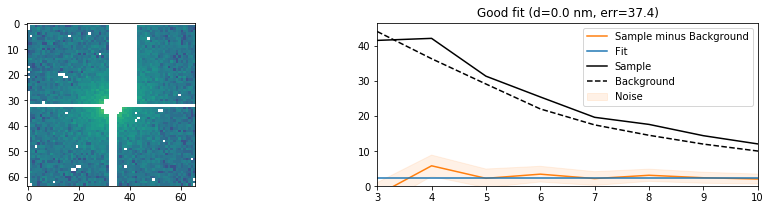

5.226475808643554 1.73246385634


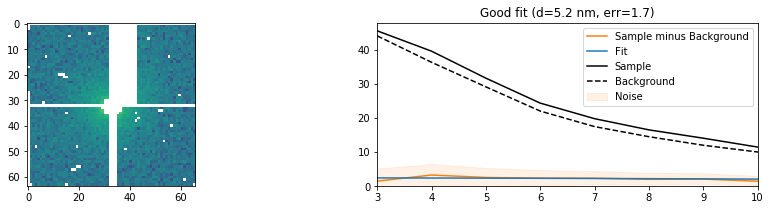

In [404]:
do_plot = True

N_fit = 200
errs_fit_sample = np.zeros(N_fit)
ds_fit_sample   = np.zeros(N_fit)

for k in range(0, N_fit):
    i_sample = nph_sample.argsort()[-k-1]

    Ir_sample = spimage.radialMeanImage(img=data_sample[i_sample], msk=mask_sample[i_sample], cx=32, cy=32)
    Ir_bg     = spimage.radialMeanImage(img=data_bg_mean, msk=mask0, cx=cx, cy=cy)
    Ir_std    = spimage.radialMeanImage(img=sqrt(data_bg_var), msk=mask0, cx=cx, cy=cy)
    Ir_diff   = Ir_sample - Ir_bg

    K_guess = Ir_diff.max()*1.3
    d_guess = 30.

    Ir_guess  = Ir_sphere(K_guess, d_guess)
    (K_fit, d_fit), err_fit = fit_sphere(Ir_diff, K_guess, d_guess)
    errs_fit_sample[k] = err_fit
    ds_fit_sample[k]   = d_fit
    Ir_model  = Ir_sphere(K_fit, d_fit)

    if do_plot and k%(N_fit//10)==0:
        print d_fit, err_fit
        fig, (ax1, ax2) = subplots(1, 2, figsize=(15, 3))
        ax1.imshow(imgs_sample[i_sample], norm=LogNorm(vmin=0.1, vmax=1000))
        if err_fit > 100.:
            ax2.set_title('Bad fit (d=%.1f nm, err=%.1f)' % (d_fit, err_fit))
        else:
            ax2.set_title('Good fit (d=%.1f nm, err=%.1f)' % (d_fit, err_fit))
        ax2.fill_between(rpix, Ir_diff-Ir_std/2., Ir_diff+Ir_std/2., label='Noise', color='C1', alpha=0.1)
        ax2.plot(rpix, Ir_diff, label='Sample minus Background', color='C1')
        #ax2.fill_between(Ir_diff-Ir_std/2., Ir_diff-Ir_std/2., label='Sample minus background')
        ax2.plot(rpix, Ir_model, label='Fit')
        ax2.plot(rpix, Ir_sample, label='Sample', color='k')
        ax2.plot(rpix, Ir_bg, label='Background', color='k', ls='--')
        #ax2.plot(Ir_std, label='Std')
        #ax2.plot(Ir_guess, label='Guess')
        ax2.set_ylim(0.1, None)
        ax2.set_xlim(3, 10)
        ax2.legend()
        show()

(array([ 2.,  0.,  0.,  0.,  0.,  1., 13.,  1.,  3.,  3.,  5., 13.,  7.,
         7.,  9.,  6., 12.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,
         1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.]), array([-11.4195443 ,  -9.53075711,  -7.64196992,  -5.75318273,
         -3.86439554,  -1.97560835,  -0.08682115,   1.80196604,
          3.69075323,   5.57954042,   7.46832761,   9.3571148 ,
         11.24590199,  13.13468918,  15.02347637,  16.91226356,
         18.80105075,  20.68983794,  22.57862513,  24.46741233,
         26.35619952,  28.24498671,  30.1337739 ,  32.02256109,
         33.91134828,  35.80013547,  37.68892266,  39.57770985,
         41.46649704,  43.35528423,  45.24407142,  47.13285861,
         49.02164581,  50.910433  ,  52.79922019,  54.68800738,
         56.57679457,  58.46558176,  60.35436895,  62.24315614,
         64.13194333]), <a list of 40 Patch objects>)

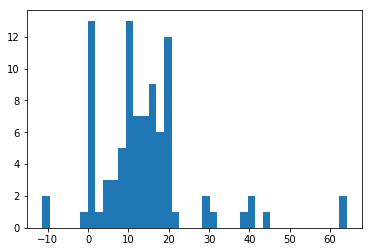

In [377]:
# run 254
hist(ds_fit[errs_fit<100.], 40)

(array([ 2.,  0.,  0., 15.,  1.,  2.,  1.,  4.,  6.,  3.,  3., 11., 10.,
        11.,  7.,  4.,  1.,  0.,  1.,  6.,  1.,  1.,  1.,  0.,  0.,  0.,
         2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         2.]),
 array([-6.53419115, -4.72209742, -2.9100037 , -1.09790997,  0.71418376,
         2.52627749,  4.33837122,  6.15046495,  7.96255868,  9.7746524 ,
        11.58674613, 13.39883986, 15.21093359, 17.02302732, 18.83512105,
        20.64721478, 22.4593085 , 24.27140223, 26.08349596, 27.89558969,
        29.70768342, 31.51977715, 33.33187088, 35.1439646 , 36.95605833,
        38.76815206, 40.58024579, 42.39233952, 44.20443325, 46.01652698,
        47.82862071, 49.64071443, 51.45280816, 53.26490189, 55.07699562,
        56.88908935, 58.70118308, 60.51327681, 62.32537053, 64.13746426,
        65.94955799]),
 <a list of 40 Patch objects>)

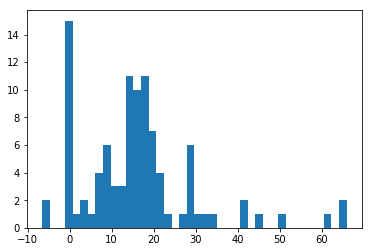

In [363]:
# run 253
hist(ds_fit[errs_fit<100.], 40)

(array([23.,  2.,  6.,  7., 17., 16., 20., 28., 16.,  8.,  6.,  7.,  4.,
         2.,  5.,  1.,  1.,  3.,  0.,  3.,  2.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects>)

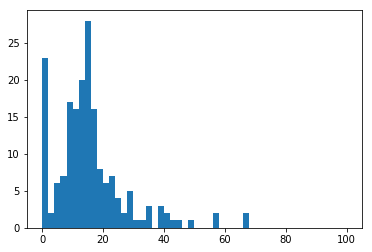

In [400]:
# run 252
hist(ds_fit_sample[errs_fit<200.], 50, range=(0, 100))

Do same fitting with background data

0.05753596467772104 13.0997264587


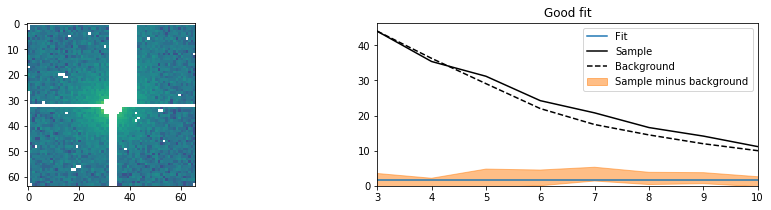

12.74025608105349 15.3463861667


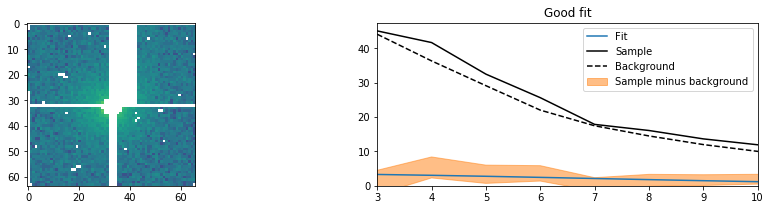

-0.00020582374101120481 10.6494162039


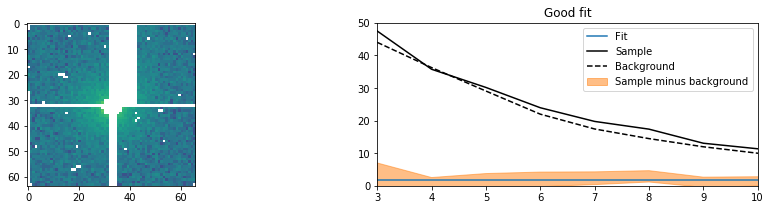

30.035931869401697 3.55411147313


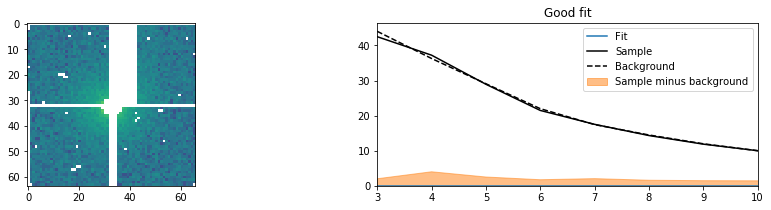

29.86356010821566 32.7294125765


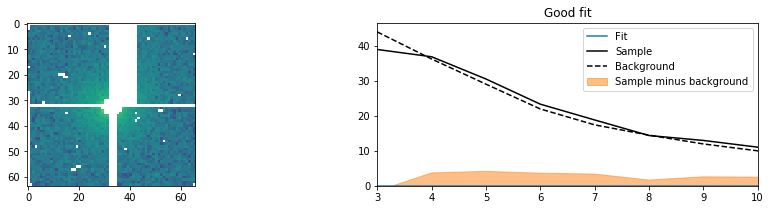

30.759371673127404 103.445145437


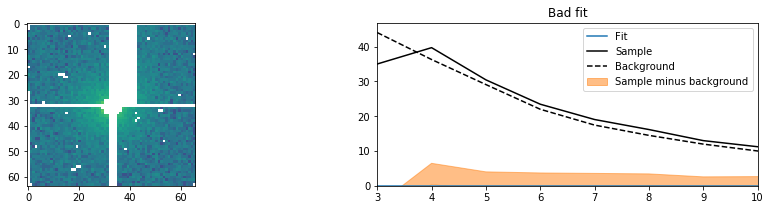

26.13456409033705 30.2399587007


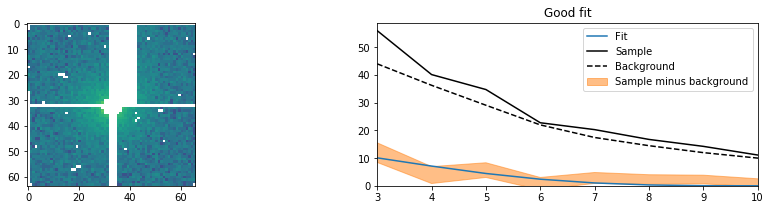

9.87308287201002 13.2463709932


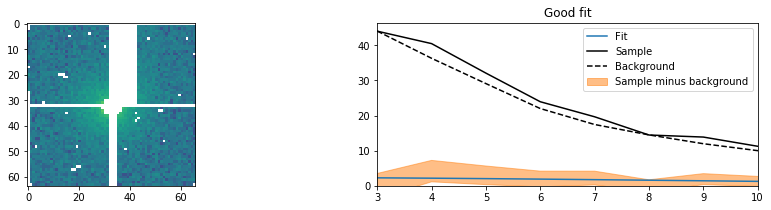

9.28686215976402 9.93676994483


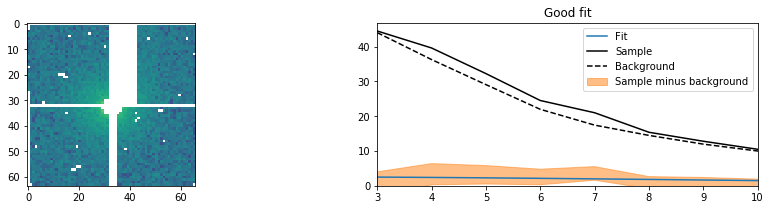

0.045092378753724405 1.82571864024


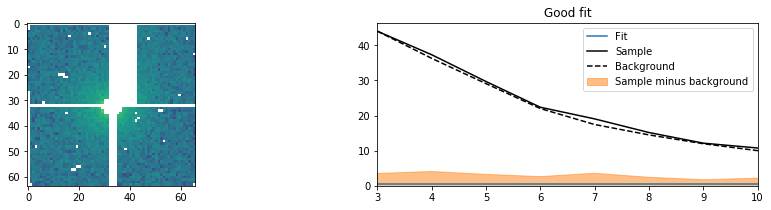

In [418]:
do_plot = True

N_fit = 100
errs_fit_bg = np.zeros(N_fit)
ds_fit_bg   = np.zeros(N_fit)

for k in range(0, N_fit):
    i = nph_bg.argsort()[-k-1]

    Ir_sample = spimage.radialMeanImage(img=data_bg[i], msk=mask_bg[i], cx=32, cy=32)
    Ir_bg     = spimage.radialMeanImage(img=data_bg_mean, msk=mask0, cx=cx, cy=cy)
    Ir_std    = spimage.radialMeanImage(img=sqrt(data_bg_var), msk=mask0, cx=cx, cy=cy)
    Ir_diff   = Ir_sample - Ir_bg

    K_guess = Ir_diff.max()*1.3
    d_guess = 30.

    Ir_guess  = Ir_sphere(K_guess, d_guess)
    (K_fit, d_fit), err_fit = fit_sphere(Ir_diff, K_guess, d_guess)
    errs_fit_bg[k] = err_fit
    ds_fit_bg[k]   = d_fit
    Ir_model  = Ir_sphere(K_fit, d_fit)

    if do_plot and k%(N_fit//10)==0:
        print d_fit, err_fit
        fig, (ax1, ax2) = subplots(1, 2, figsize=(15, 3))
        ax1.imshow(imgs_sample[i_sample], norm=LogNorm(vmin=0.1, vmax=1000))
        if err_fit > 100.:
            ax2.set_title('Bad fit')
        else:
            ax2.set_title('Good fit')
        ax2.fill_between(rpix, Ir_diff-Ir_std/2., Ir_diff+Ir_std/2., label='Sample minus background', color='C1', alpha=0.5)
        #ax2.fill_between(Ir_diff-Ir_std/2., Ir_diff-Ir_std/2., label='Sample minus background')
        ax2.plot(rpix, Ir_model, label='Fit')
        ax2.plot(rpix, Ir_sample, label='Sample', color='k')
        ax2.plot(rpix, Ir_bg, label='Background', color='k', ls='--')
        #ax2.plot(Ir_std, label='Std')
        #ax2.plot(Ir_guess, label='Guess')
        ax2.set_ylim(0., None)
        ax2.set_xlim(3, 10)
        ax2.legend()
        show()

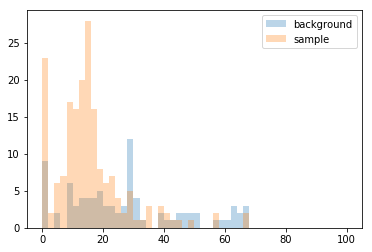

In [420]:
hist(ds_fit_bg[errs_fit_bg<200.], 50, range=(0, 100), alpha=0.3, label='background')
hist(ds_fit_sample[errs_fit_sample<200.], 50, range=(0, 100), alpha=0.3, label='sample')
legend()

In [ ]:
# Sanity:
# Intensities? What order of magnitude?
# Add buffer run?
# Error metric
# Try: Scale background by fitting parameter (maybe only refinement)